<a href="https://colab.research.google.com/github/miquelmassot/detectron2_heatmaps/blob/main/Detectron2_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wujuypzw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wujuypzw
  Resolved https://github.com/facebookresearch/detectron2.git to commit 1523b3e9929a06d798871eb9afc4c9f770743baf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cv2
import os
import json
import numpy as np
from pathlib import Path
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from google.colab.patches import cv2_imshow

In [ ]:
def get_balloon_dicts(img_dir='oplab_dataset'):
    dataset_dicts = []

    # Find all images in the folder
    img_path = Path(img_dir)
    idx = 0
    for img in img_path.glob("*.jpg"):
        if "mask" in img.stem:
            continue
        print("Found image: ", img.stem)
        mask_img = img_path / (img.stem + "_mask.jpg")

        record = {}
        height, width = cv2.imread(str(img)).shape[:2]
        mask = cv2.imread(str(mask_img), cv2.IMREAD_GRAYSCALE)
        record["file_name"] = str(img)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        obj = {
            "bbox": [0, 0, width, height],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": [mask],
            "category_id": 0,
        }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        idx += 1
    return dataset_dicts

DatasetCatalog.clear()
DatasetCatalog.register("oplab_dataset", get_balloon_dicts)
MetadataCatalog.get("oplab_dataset").set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("oplab_dataset")

dataset_dicts = get_balloon_dicts("oplab_dataset")

Found image:  A
Found image:  B


In [ ]:
print(dataset_dicts)

[{'file_name': 'oplab_dataset/A.jpg', 'image_id': 0, 'height': 768, 'width': 1024, 'annotations': [{'bbox': [0, 0, 1024, 768], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)], 'category_id': 0}]}, {'file_name': 'oplab_dataset/B.jpg', 'image_id': 1, 'height': 683, 'width': 1024, 'annotations': [{'bbox': [0, 0, 1024, 683], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)], 'category_id': 0}]}]


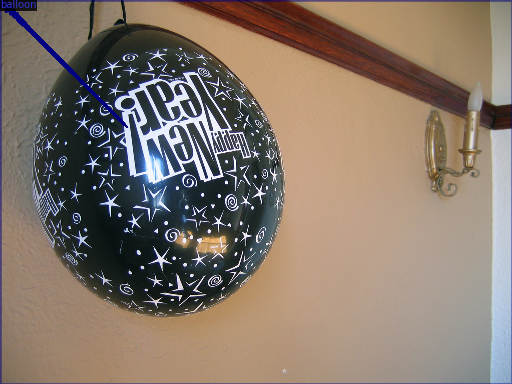

In [ ]:
d = dataset_dicts[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("oplab_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 50    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


"""
https://github.com/facebookresearch/detectron2/issues/196

Warning messages are to be expected as the number of classes of the used model 
(mask_rcnn_R_50_FPN_3x) differs from the number of classes of our dummy dataset 
(e.g. 1, baloon)
"""

[02/13 15:53:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[02/13 15:53:54 d2.engine.train_loop]: Starting training from iteration 0
[02/13 15:54:16 d2.utils.events]:  eta: 0:00:27  iter: 19  total_loss: 1.473  loss_cls: 0.5066  loss_box_reg: 0.2491  loss_mask: 0.6041  loss_rpn_cls: 0.01362  loss_rpn_loc: 0.08512  time: 0.8948  data_time: 0.1039  lr: 9.5155e-05  max_mem: 4426M
[02/13 15:54:34 d2.utils.events]:  eta: 0:00:08  iter: 39  total_loss: 0.592  loss_cls: 0.1603  loss_box_reg: 0.2343  loss_mask: 0.1155  loss_rpn_cls: 0.003902  loss_rpn_loc: 0.05184  time: 0.8921  data_time: 0.0353  lr: 0.00019506  max_mem: 4426M
[02/13 15:54:45 d2.utils.events]:  eta: 0:00:00  iter: 49  total_loss: 0.4458  loss_cls: 0.1266  loss_box_reg: 0.2261  loss_mask: 0.05617  loss_rpn_cls: 0.001372  loss_rpn_loc: 0.03705  time: 0.9015  data_time: 0.0375  lr: 0.00024501  max_mem: 4426M
[02/13 15:54:45 d2.engine.hooks]: Overall training speed: 48 iterations in 0:00:43 (0.9015 s / it)
[02/13 15:54:45 d2.engine.hooks]: Total training time: 0:00:44 (0:00:01 on hooks)
